<a href="https://colab.research.google.com/github/nrshaidat/epitope/blob/master/Random_Forestipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [1]:
# Pandas is used for data manipulation
!pip install biopython
import re
#from google.colab import drive
#drive.mount('/content/drive')
import pandas as pd
from Bio import SeqIO
import os
def getEpitope(seq):
  patterns= ['[A-Z]+']
  for p in patterns:
    match = re.findall(p, phrase)
    return match



#os.chdir("/content/drive/MyDrive")
#!rm -rf epitope/
!git clone https://github.com/nrshaidat/epitope.git
#os.chdir("epitope/")
!ls
# Read in data as pandas dataframe and display first 5 rows

linear_epitopes = "/content/epitope/data/iedb_linear_epitopes.fasta"
structural_epitopes = "/content/epitope/data/pdb_chains.fasta"
db = []
maxn = 0
neg = 0
for record in SeqIO.parse(linear_epitopes, "fasta"):
    #print(record.id)
    line = record.id.split('_')
    seq = str(record.seq).upper()
    n = len(seq)
    if line[0] == 'NegativeID':
      neg+=1
      row = [line[1], seq, n, 0]
    else:
      maxn = max(n, maxn)
      row = [line[1], seq, n, 1]
    db.append(row)
df = pd.DataFrame(db,columns=['id', 'seq', 'size', 'epitope'])
print(df.shape)
print(neg)


     |████████████████████████████████| 2.3MB 8.5MB/s 
Cloning into 'epitope'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5 (delta 0), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.
epitope  sample_data
(30556, 4)
18722


In [35]:
# Pandas is used for data manipulation
!pip install biopython
import re
#from google.colab import drive
#drive.mount('/content/drive')
import pandas as pd
from Bio import SeqIO
import os
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
blood_ph = 7.40
def getEpitope(seq):
  patterns= ['[A-Z]+']
  for p in patterns:
    match = re.findall(p, seq)
    return match
codes = ['A', 'B','C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K', 'L',
         'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U','V', 'W','X','Y', 'Z']
def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1
  return char_dict
char_dict = create_dict(codes)
def integer_encoding(row):
  row_encode = []
  for code in row:
    num = char_dict[code]
    row_encode.append(char_dict[code])
  return np.array(row_encode)

def getFeatures(seq, label):
  peptide_vals = []
  protein = ProteinAnalysis(seq)
  num_aminos = len(seq)
  peptide_vals.append(num_aminos)
  isoelectric_point = protein.isoelectric_point()
  peptide_vals.append(isoelectric_point)
  charge_blood_ph = protein.charge_at_pH(blood_ph)
  peptide_vals.append(charge_blood_ph)
  aromacity = protein.aromaticity()
  peptide_vals.append(aromacity)
  instability_index = protein.instability_index()
  peptide_vals.append(instability_index)
  mol_weight = protein.molecular_weight()
  peptide_vals.append(mol_weight)
  gravy_score = protein.gravy() # GRAVY refers to grand average of hydropathy. The hydropathy index of an amino acid is a number representing the hydrophobic or hydrophilic properties of its side-chain
  peptide_vals.append(gravy_score)
  peptide_vals.append(label)
  #seq_encoded = integer_encoding(seq)
  #peptide_vals.extend(seq_encoded)
  print(peptide_vals)
  return peptide_vals
#os.chdir("/content/drive/MyDrive")
#!rm -rf epitope/
#!git clone https://github.com/nrshaidat/epitope.git
#os.chdir("epitope/")
!ls
# Read in data as pandas dataframe and display first 5 rows

linear_epitopes = "/content/epitope/data/iedb_linear_epitopes.fasta"
structural_epitopes = "/content/epitope/data/pdb_chains.fasta"
db = []
neg = 0
column_seq = []
for i in range(24):
  coll = 'pos'+str(i)
  column_seq.append(coll)
columns_lab = ['id', 'size', 'isoelectric_point', 'charge','aromacity','instability_index', 'molecular_wt','gravy','label']
columns_lab.extend(column_seq)
for record in SeqIO.parse(linear_epitopes, "fasta"):
    #print(record.id)
    line = record.id.split('_')
    epitope = getEpitope(str(record.seq))
    #seq = str(record.seq).upper()
    n = len(epitope[0])
    if line[0] == 'NegativeID':
      neg+=1
      more_features = getFeatures(epitope[0], 0)
      row = more_features
    else:
      more_features = getFeatures(epitope[0], 1)
      row = more_features
    db.append(row)
df = pd.DataFrame(db,columns=['size', 'isoelectric_point', 'charge','aromacity','instability_index', 'molecular_wt','gravy','label'])
print(df.shape)
print(df)

Streaming output truncated to the last 5000 lines.
[12, 7.7775465011596685, 0.2007274005685722, 0.08333333333333333, 58.758333333333326, 1470.6734, -1.2916666666666667, 0]
[8, 11.999967765808105, 1.901277826459578, 0.0, 62.125000000000014, 907.0947999999999, -1.7375, 0]
[8, 8.750052070617677, 0.5549472748996638, 0.0, -16.075, 854.0055, -0.0500000000000001, 0]
[15, 8.743153953552245, 0.556439165294393, 0.06666666666666667, 25.226666666666667, 1686.8265000000001, -1.36, 0]
[7, 5.240009498596191, -0.7467716876242864, 0.0, -3.5571428571428574, 591.6119, 0.6571428571428573, 0]
[10, 4.536456489562989, -2.406412554674435, 0.0, -7.98, 1127.1622, -1.4400000000000002, 0]
[12, 6.743628120422364, -0.4080049180026579, 0.16666666666666666, 41.26666666666667, 1448.5813, -0.4249999999999999, 0]
[15, 6.062583351135253, -0.4680139657891962, 0.0, 85.1, 1647.8485, -0.5199999999999999, 0]
[15, 9.994291877746583, 1.552863048154009, 0.0, -6.38, 1628.0126, -0.013333333333333345, 0]
[15, 4.0500284194946286, -3

In [ ]:
import re
phrase = "masqkrpsqrhgskylatastmdharhgflprhrdtgildsigrffggdrgapkrgsgkdshhpartahygslpqKSHGRTQDENPVVHFFKNIVTPRTpppsqgkgrglslsrfswgaegqrpgfgyggrasdyksahkgfkgvdaqgtlskifklggrdsrsgspmarr"
patterns= ['[A-Z]+']
for p in patterns:
  match = re.findall(p, phrase)
  print(match)
  print(len(match[0]))

['KSHGRTQDENPVVHFFKNIVTPRT']
24


## Features and Labels

In [36]:
import numpy as np


# Labels are the values we want to predict
labels = np.array(df['label'])
newdf = df.copy(deep = True)
# Remove the labels from the features
# axis 1 refers to the columns
newdf = newdf.drop('label', axis = 1)

# Saving feature names for later use
feature_list = list(newdf.columns)

# Convert to numpy array
features = np.array(newdf)
  


In [2]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(df['epitope'])
newdf = df.copy(deep = True)
# Remove the labels from the features
# axis 1 refers to the columns
newdf = newdf.drop('epitope', axis = 1)

# Saving feature names for later use
feature_list = list(df.columns)

# Convert to numpy array
features = np.array(newdf)


## Training and Testing Sets

In [3]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
codes = ['A', 'B','C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K', 'L',
         'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U','V', 'W','X','Y', 'Z']
def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1
  return char_dict
char_dict = create_dict(codes)

def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  encode_list = []
  for row in data[:,1]:
    row_encode = []
    for code in row:
      num = char_dict[code]
      row_encode.append(char_dict[code])
    encode_list.append(np.array(row_encode))
  return encode_list
  
features = integer_encoding(features) 


max_length = 34350
features = pad_sequences(features, maxlen=max_length, padding='post', truncating='post')




# # One hot encoding of sequences
# train_ohe = to_categorical(train_pad)
# test_ohe = to_categorical(test_pad)




In [37]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 0)


In [38]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (22917, 7)
Training Labels Shape: (22917,)
Testing Features Shape: (7639, 7)
Testing Labels Shape: (7639,)


## Establish Baseline

## Training the Forest

In [39]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model 
rf = RandomForestClassifier(random_state = 0)

# Train the model on training data
rf.fit(train_features, train_labels);

We can create models with different hyperparameters to try and boost performance. The only way to find the best ones
are to try a few and evaluate them! 

## Make Predictions on Test Data

In [40]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
correct = 0
for pred, true_prediction in zip(predictions, test_labels):
  correct += pred == true_prediction
accuracy = (correct * 1.0) / len(test_labels)
print(accuracy)



0.7188113627438146


In [10]:
from keras.preprocessing.sequence import pad_sequences
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(df['epitope'])
newdf = df.copy(deep = True)
# Remove the labels from the features
# axis 1 refers to the columns
newdf = newdf.drop('epitope', axis = 1)

# Saving feature names for later use
feature_list = list(df.columns)

# Convert to numpy array
features = np.array(newdf)
codes = ['A', 'B','C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K', 'L',
         'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U','V', 'W','X','Y', 'Z']
def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1
  return char_dict
char_dict = create_dict(codes)
def integer_encoding_full(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  encode_list = []
  for row in data[:,1]:
    row_encode = []
    for code in row:
      num = char_dict[code]
      row_encode.append(char_dict[code])
    encode_list.append(np.array(row_encode))
  return encode_list
  
features = integer_encoding_full(features) 


max_length = 34350
features = pad_sequences(features, maxlen=max_length, padding='post', truncating='post')


# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 0)

# Instantiate model 
rf = RandomForestClassifier(random_state = 0)

# Train the model on training data
rf.fit(train_features, train_labels);
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
correct = 0
for pred, true_prediction in zip(predictions, test_labels):
  correct += pred == true_prediction
accuracy = (correct * 1.0) / len(test_labels)
print(accuracy)

spikeseq = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"


def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  row_encode = []
  for code in data:
    num = char_dict[code]
    row_encode.append(char_dict[code])
  return np.array(row_encode)
  
spikefeat = integer_encoding(spikeseq) 


max_length = 34350
def padarray(A, size):
  t = size - len(A)
  return np.pad(A, pad_width=(0, t), mode='constant')

spikefeat = padarray(spikefeat, max_length) 
pred = rf.predict(spikefeat.reshape(1,-1))
print(pred)


[1]


In [53]:
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP
from Bio.SeqUtils.ProtParam import ProteinAnalysis
blood_ph = 7.40
def split_sequence(sequence, subsequence_length):
  peptide_list = []
  num = len(sequence.strip()) - subsequence_length + 1
  for i in range(num):
    peptide = sequence[i:i + subsequence_length]
    peptide_list.append(peptide)
  return peptide_list
spikeseq = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
peptide = spikeseq[306:528]
peptide_vals = []
protein = ProteinAnalysis(peptide)
size = len(peptide)
peptide_vals.append(size)
isoelectric_point = protein.isoelectric_point()
peptide_vals.append(isoelectric_point)
charge_blood_ph = protein.charge_at_pH(blood_ph)
peptide_vals.append(charge_blood_ph)
aromacity = protein.aromaticity()
peptide_vals.append(aromacity)
instability_index = protein.instability_index()
peptide_vals.append(instability_index)
mol_weight = protein.molecular_weight()
peptide_vals.append(mol_weight)
gravy_score = protein.gravy() # GRAVY refers to grand average of hydropathy. The hydropathy index of an amino acid is a number representing the hydrophobic or hydrophilic properties of its side-chain
peptide_vals.append(gravy_score)
pred = rf.predict(np.array(peptide_vals).reshape(1,-1))
print("RBD " + str(pred[0]))

for i in range(16, 17): # do from 5 to 26
  #spike_peptides = [spikeseq[i:i + 16] for i in range(0, 1265, 16)]
  spike_peptides = split_sequence(spikeseq, i)
  #spike_peptides.append(spikeseq)
  num_epitopes = 0
  num_non = 0
  for peptide in spike_peptides:
    peptide_vals = []
    protein = ProteinAnalysis(peptide)
    size = len(peptide)
    peptide_vals.append(size)
    isoelectric_point = protein.isoelectric_point()
    peptide_vals.append(isoelectric_point)
    charge_blood_ph = protein.charge_at_pH(blood_ph)
    peptide_vals.append(charge_blood_ph)
    aromacity = protein.aromaticity()
    peptide_vals.append(aromacity)
    instability_index = protein.instability_index()
    peptide_vals.append(instability_index)
    mol_weight = protein.molecular_weight()
    peptide_vals.append(mol_weight)
    gravy_score = protein.gravy() # GRAVY refers to grand average of hydropathy. The hydropathy index of an amino acid is a number representing the hydrophobic or hydrophilic properties of its side-chain
    peptide_vals.append(gravy_score)
    pred = rf.predict(np.array(peptide_vals).reshape(1,-1))
    if pred[0] == 1:
      num_epitopes +=1
      print(str(pred[0]) + " FOUND EPITOPE HERE   " + peptide)
    else:
      num_non +=1
print(num_epitopes)
print(num_non)



RBD 0
1 FOUND EPITOPE HERE   LPLVSSQCVNLTTRTQ
1 FOUND EPITOPE HERE   PLVSSQCVNLTTRTQL
1 FOUND EPITOPE HERE   LVSSQCVNLTTRTQLP
1 FOUND EPITOPE HERE   VSSQCVNLTTRTQLPP
1 FOUND EPITOPE HERE   SQCVNLTTRTQLPPAY
1 FOUND EPITOPE HERE   QCVNLTTRTQLPPAYT
1 FOUND EPITOPE HERE   CVNLTTRTQLPPAYTN
1 FOUND EPITOPE HERE   VNLTTRTQLPPAYTNS
1 FOUND EPITOPE HERE   NLTTRTQLPPAYTNSF
1 FOUND EPITOPE HERE   LTTRTQLPPAYTNSFT
1 FOUND EPITOPE HERE   TTRTQLPPAYTNSFTR
1 FOUND EPITOPE HERE   TRTQLPPAYTNSFTRG
1 FOUND EPITOPE HERE   QLPPAYTNSFTRGVYY
1 FOUND EPITOPE HERE   LPPAYTNSFTRGVYYP
1 FOUND EPITOPE HERE   PAYTNSFTRGVYYPDK
1 FOUND EPITOPE HERE   AYTNSFTRGVYYPDKV
1 FOUND EPITOPE HERE   YTNSFTRGVYYPDKVF
1 FOUND EPITOPE HERE   TNSFTRGVYYPDKVFR
1 FOUND EPITOPE HERE   NSFTRGVYYPDKVFRS
1 FOUND EPITOPE HERE   SFTRGVYYPDKVFRSS
1 FOUND EPITOPE HERE   FTRGVYYPDKVFRSSV
1 FOUND EPITOPE HERE   TRGVYYPDKVFRSSVL
1 FOUND EPITOPE HERE   RGVYYPDKVFRSSVLH
1 FOUND EPITOPE HERE   GVYYPDKVFRSSVLHS
1 FOUND EPITOPE HERE   VYYPDKVFRSS

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = [‘auto’, ‘sqrt’]

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 ‘n_estimators’: n_estimators,
 ‘max_features’: max_features,
 ‘max_depth’: max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

In [ ]:
rfc = RandomForestClassifier(n_estimators=600, max_depth=300, max_features='sqrt')
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

In [65]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
feature_list = list(newdf.columns)
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [71]:
# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 4, criterion='entropy')
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'mid_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('mid_tree.dot')
graph.write_png('mid_tree.png');

['size', 'isoelectric_point', 'charge', 'aromacity', 'instability_index', 'molecular_wt', 'gravy']
{0: 'size', 1: 'isoelectric_point', 2: 'charge', 3: 'aromacity', 4: 'instability_index', 5: 'molecular_wt', 6: 'gravy'}
Feature ranking:
1. feature molecular_wt (0.206510)
2. feature gravy (0.166039)
3. feature instability_index (0.159499)
4. feature charge (0.151069)
5. feature size (0.132136)
6. feature isoelectric_point (0.126623)
7. feature aromacity (0.058124)


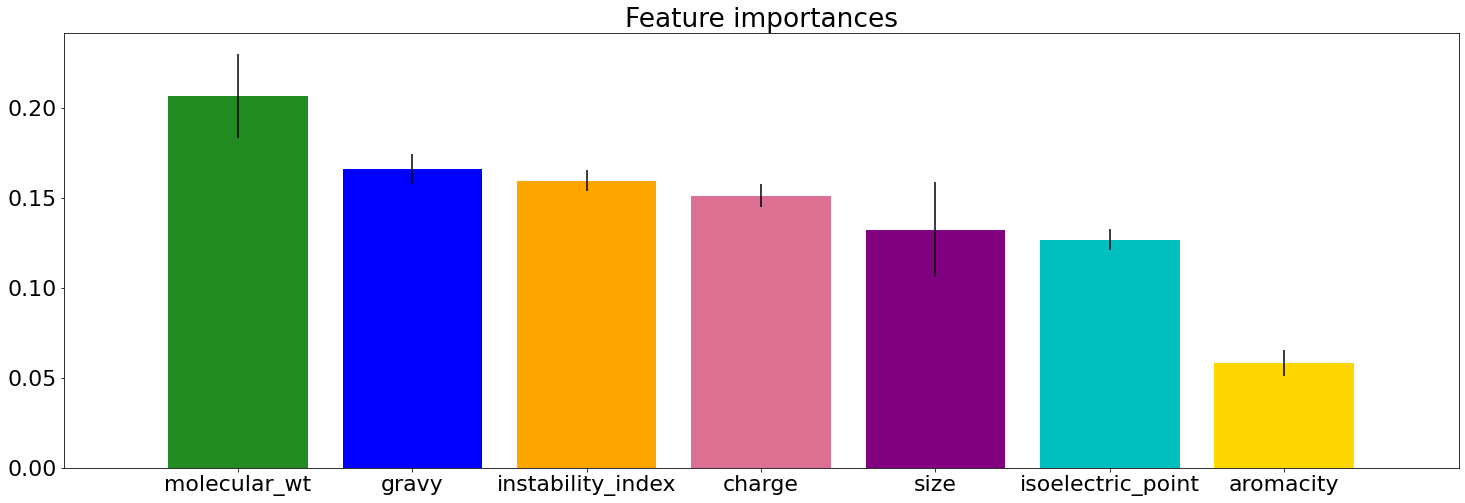

In [87]:
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 25
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams.update({'font.size': 22})
feature_list = list(newdf.columns)
print(feature_list)
feature_dict = {}
for i, val in enumerate(feature_list):
  feature_dict[i] = val
print(feature_dict)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feature_imp = pd.Series(rf.feature_importances_,index=feature_list).sort_values(ascending=False)
X = train_features
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_dict[indices[f]], importances[indices[f]]))
name_indices = []
for i in indices:
  name_indices.append(feature_dict[i])
name_indices = np.array(name_indices)
# Plot the impurity-based feature importances of the forest
plt.figure()
colors = ['y','r','b']
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color=['forestgreen','b','orange','palevioletred','purple', 'c', 'gold'], yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), name_indices)
plt.xlim([-1, X.shape[1]])
plt.savefig('importance_plot.png', dpi=360, facecolor='w', edgecolor='w')
plt.show()



In [23]:

codes = ['A', 'B','C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K', 'L',
         'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U','V', 'W','X','Y', 'Z']
def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1
  return char_dict
char_dict = create_dict(codes)
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  row_encode = []
  for code in data:
    num = char_dict[code]
    row_encode.append(char_dict[code])
  return np.array(row_encode)
spikeseq = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
rbd = spikeseq[306:528]
e_protein = "MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNIVNVSLVKPSFYVYSRVKNLNSSRVPDLLV"
n_protein = "MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNTASWFTALTQHGKEDLKFPRGQGVPINTNSSPDDQIGYYRRATRRIRGGDGKMKDLSPRWYFYYLGTGPEAGLPYGANKDGIIWVATEGALNTPKDHIGTRNPANNAAIVLQLPQGTTLPKGFYAEGSRGGSQASSRSSSRSRNSSRNSTPGSSRGTSPARMAGNGGDAALALLLLDRLNQLESKMSGKGQQQQGQTVTKKSAAEASKKPRQKRTATKAYNVTQAFGRRGPEQTQGNFGDQELIRQGTDYKHWPQIAQFAPSASAFFGMSRIGMEVTPSGTWLTYTGAIKLDDKDPNFKDQVILLNKHIDAYKTFPPTEPKKDKKKKADETQALPQRQKKQQTVTLLPAADLDDFSKQLQQSMSSADSTQA"
spikefeat = integer_encoding(rbd) 


306-527
max_length = 34350
def padarray(A, size):
  t = size - len(A)
  return np.pad(A, pad_width=(0, t), mode='constant')

spikefeat = padarray(spikefeat, max_length) 
pred = rf.predict(spikefeat.reshape(1,-1))
print(pred)

[1]
